#Preparation of Environment


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Comp 550 NLP/financial_sentiment_data.csv"

Mounted at /content/drive/
ls: cannot access '/content/drive/My Drive/Comp 550 NLP/financial_sentiment_data.csv': No such file or directory


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import nltk
from nltk.corpus import stopwords
import pandas as pd
import csv
import torch




---


#Dataset Preparation


In [ ]:
import pandas as pd

# Load the CSV file into a DataFrame with a different encoding
file_path = "/content/drive/MyDrive/COMP550_Final_Project/financial_sentiment_data.csv"
df = pd.read_csv(file_path, encoding='latin-1', header=None, names=['Sentiment', 'Text'])

# Define a mapping dictionary
sentiment_mapping = {'neutral': 1, 'positive': 2, 'negative': 0}

# Map the labels to numerical values using the dictionary
df['Encoded_Sentiment'] = df['Sentiment'].map(sentiment_mapping)

# Display the updated DataFrame
print(df[['Sentiment', 'Encoded_Sentiment']])


# Display the DataFrame
df.head()

     Sentiment  Encoded_Sentiment
0      neutral                  1
1      neutral                  1
2     negative                  0
3     positive                  2
4     positive                  2
...        ...                ...
4841  negative                  0
4842   neutral                  1
4843  negative                  0
4844  negative                  0
4845  negative                  0

[4846 rows x 2 columns]


,Sentiment,Text,Encoded_Sentiment
0,neutral,"According to Gran , the company has no plans t...",1
1,neutral,Technopolis plans to develop in stages an area...,1
2,negative,The international electronic industry company ...,0
3,positive,With the new production plant the company woul...,2
4,positive,According to the company 's updated strategy f...,2


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')  # Download the Punkt tokenizer data
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

preprocessed_texts = []

for text in df['Text']:
    tokens = word_tokenize(text)
    new_tokens = []
    for word in tokens:
        if word.isalnum() and word.lower() not in stop_words:
            lemmatized_word = lemmatizer.lemmatize(word.lower())
            new_tokens.append(lemmatized_word)
    preprocessed_texts.append(' '.join(new_tokens))

# Create a new column in the DataFrame for the preprocessed text
df['Preprocessed_Text'] = preprocessed_texts

# Display the DataFrame with the new column
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Sentiment,Text,Encoded_Sentiment,Preprocessed_Text
0,neutral,"According to Gran , the company has no plans t...",1,according gran company plan move production ru...
1,neutral,Technopolis plans to develop in stages an area...,1,technopolis plan develop stage area le square ...
2,negative,The international electronic industry company ...,0,international electronic industry company elco...
3,positive,With the new production plant the company woul...,2,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,2,according company updated strategy year baswar...


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'Sentiment' is the column containing your labels
categories = df['Encoded_Sentiment']

# Split the data into training+validation and test sets
preprocessed_train_val_texts, preprocessed_test_texts, y_train_val, y_test = train_test_split(
    df['Preprocessed_Text'], categories, test_size=0.2, random_state=42
)

# Further split the training+validation set into training and validation sets
preprocessed_train_texts, preprocessed_val_texts, y_train, y_val = train_test_split(
    preprocessed_train_val_texts, y_train_val, test_size=0.2, random_state=42
)

# Display the results
print("Train val Texts:")
print(preprocessed_train_val_texts.head())
print("\nTraining Labels:")
print(y_train.head())


Train val Texts:
432     russia raisio food division home market stretc...
3071    operator need learn use one device multiple le...
289     company expects net sale first half 2008 reach...
2588    bridge km long located anasmotet road e20 new ...
4121    nokia capcom announced resident evil degenerat...
Name: Preprocessed_Text, dtype: object

Training Labels:
3618    1
1630    1
4303    0
2575    1
3914    2
Name: Encoded_Sentiment, dtype: int64


#Linear Classifiers

##Naive Bayes Model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline with a CountVectorizer and a Multinomial Naive Bayes classifier
model = make_pipeline(CountVectorizer(), MultinomialNB())

# Fit the model on the training data
model.fit(preprocessed_train_texts, y_train)

# Predict on the validation set
y_val_pred = model.predict(preprocessed_val_texts)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.2%}")

# Display classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 69.97%
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.51      0.56        99
           1       0.76      0.85      0.80       466
           2       0.55      0.46      0.50       211

    accuracy                           0.70       776
   macro avg       0.65      0.61      0.62       776
weighted avg       0.69      0.70      0.69       776



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Hyperparameter Tuning for Multinomial Naive Bayes
nb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

nb_param_grid = {
    'vectorizer__binary': [True, False],
    'classifier__alpha': [0.1, 0.5, 1.0, 1.5]
}

nb_grid_search = GridSearchCV(nb_pipeline, nb_param_grid, cv=5, n_jobs=-1)
nb_grid_search.fit(preprocessed_train_texts, y_train)

# Output the best parameters and accuracy for Multinomial Naive Bayes
best_nb_params = nb_grid_search.best_params_
best_nb_accuracy = nb_grid_search.best_score_

print("Best Parameters for Multinomial Naive Bayes:")
print(best_nb_params)
print(f"Best Accuracy for Multinomial Naive Bayes: {best_nb_accuracy}")

Best Parameters for Multinomial Naive Bayes:
{'classifier__alpha': 1.5, 'vectorizer__binary': True}
Best Accuracy for Multinomial Naive Bayes: 0.7003225806451612


##Linear SVM

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# Create a pipeline with a TfidfVectorizer and a Linear SVM classifier
model = make_pipeline(TfidfVectorizer(), SVC(kernel='linear'))

# Fit the model on the training data
model.fit(preprocessed_train_texts, y_train)

# Predict on the validation set
y_val_pred = model.predict(preprocessed_val_texts)

# Evaluate the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy}")

# Display classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.7512886597938144
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.46      0.55        99
           1       0.76      0.92      0.84       466
           2       0.74      0.50      0.60       211

    accuracy                           0.75       776
   macro avg       0.73      0.63      0.66       776
weighted avg       0.75      0.75      0.74       776



In [ ]:
# Hyperparameter Tuning for Linear SVM
svm_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', SVC(kernel='linear'))
])

svm_param_grid = {
    'vectorizer__sublinear_tf': [True, False],
    'vectorizer__use_idf': [True, False],
    'classifier__C': [0.1, 0.5, 1.0, 1.5]
}

svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, n_jobs=-1)
svm_grid_search.fit(preprocessed_train_texts, y_train)

# Output the best parameters and accuracy for Linear SVM
best_svm_params = svm_grid_search.best_params_
best_svm_accuracy = svm_grid_search.best_score_

print("\nBest Parameters for Linear SVM:")
print(best_svm_params)
print(f"Best Accuracy for Linear SVM: {best_svm_accuracy:.2%}")


Best Parameters for Linear SVM:
{'classifier__C': 1.0, 'vectorizer__sublinear_tf': True, 'vectorizer__use_idf': True}
Best Accuracy for Linear SVM: 73.81%


#Comparison of Models

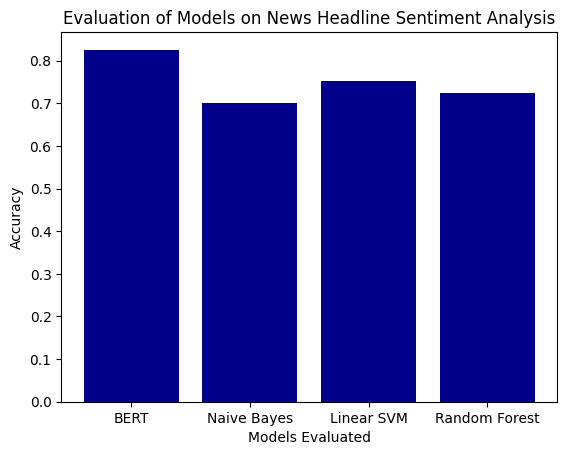

In [ ]:
categories = ['BERT', 'Naive Bayes', 'Linear SVM', 'Random Forest']
values = [0.8257731958762886, 0.7003225806451612, 0.7512886597938144, 0.7247422680412371]

# Create a bar plot
plt.bar(categories, values, color='darkblue')

# Add labels and title
plt.xlabel('Models Evaluated')
plt.ylabel('Accuracy')
plt.title('Evaluation of Models on News Headline Sentiment Analysis')

# Display the plot
plt.show()




---




